In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.stats import t
import pandas as pd
from scipy.spatial.distance import norm

In [2]:
import pandas as pd
Covid_19_data = pd.read_csv("ZAF.csv")


In [3]:
covid_data = Covid_19_data.fillna(value=0)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# Convert string columns to numeric
covid_data["confirmed"] = pd.to_numeric(covid_data["confirmed"], errors="coerce")
covid_data["deaths"] = pd.to_numeric(covid_data["deaths"], errors="coerce")
covid_data["recovered"] = pd.to_numeric(covid_data["recovered"], errors="coerce")


In [5]:
real_world_data = covid_data.iloc[84:302,1:5]
real_world_data = real_world_data.reset_index(drop=True)

In [6]:
num_confirmed = real_world_data["confirmed"]
num_deaths = real_world_data["deaths"]
num_recovered = real_world_data["recovered"]
# days_obs = real_world_data.iloc[:, 0]
days_obs = real_world_data['date']



In [7]:
days_obs1 = np.array(range(len(days_obs)))

In [8]:
num_confirmed = np.array(real_world_data["confirmed"].astype(int).values)
num_deaths = np.array(real_world_data["deaths"].astype(int).values)
num_recovered = np.array(real_world_data["recovered"].astype(int).values)
print(norm(num_confirmed))
print(num_confirmed[:5], num_confirmed.dtype)


6461765.7543478
[1170 1187 1280 1326 1353] int64


Implementing ABC rejection algorithm on the covid data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.spatial.distance import norm

def sird_model(y, t, kappa, sigma, delta):
    S, I, R, D = y
#     N = S + I + R + D  # total population
    dSdt = -kappa * S * I / N
    dIdt = kappa * S * I / N - sigma * I - delta * I
    dRdt = sigma * I
    dDdt = delta * I
    return [dSdt, dIdt, dRdt, dDdt]


In [10]:

# Parameters and initial conditions 
N = 57779622  # Total population
y0 = [N-num_confirmed[0],
      num_confirmed[0]-num_recovered[0]-num_deaths[0],
      num_recovered[0],
      num_deaths[0]
     ]

# t_obs = days_obs  # Time points to evaluate
t_obs = days_obs1

#ABC Rejection Algorithm parameters 
eps = 50000        
nmax = 1000        # Number of accepted samples desired
npilot=1000     # Number of pilot runs to determine eps for rejection sampling
nacc = 0         #counter for accepted samples
nsamp = 0        #counter for total samples attempted or priors sampled
kappa_accepted = []
sigma_accepted = []
delta_accepted= []
dist= []

In [11]:
for i in range(npilot):
    kappa= np.random.rand()
    sigma = 0.2*np.random.rand()
    delta = 0.01*np.random.rand()

    if kappa-sigma-delta > 0:
       sol=odeint(sird_model,y0,t_obs,args=(kappa,sigma,delta))
       S_sim, I_sim, R_sim, D_sim = sol.T 
       dist.append(norm(I_sim-(num_confirmed-num_recovered-num_deaths))+norm(R_sim-num_recovered)+norm(D_sim-num_deaths))

eps=np.percentile(dist,0.1)  # set eps as 1 percentile of distances
print(eps)
   



while nacc < nmax:  
    nsamp += 1
    kappa =  np.random.rand()     # Uniformly sample kappa, sigma, delta in [0, 1]
    sigma = 0.2*np.random.rand()        
    delta = 0.01*np.random.rand()

    if kappa-sigma-delta > 0:
    
#     sol = odeint(sird_model, y0, t_obs, args=(kappa,sigma,delta, N))
       sol = odeint(sird_model, y0, t_obs, args=(kappa,sigma,delta))

       S_sim, I_sim,R_sim,D_sim = sol.T    #transposed solution

       err= norm(I_sim - (num_confirmed - num_recovered - num_deaths))+norm(R_sim-num_recovered)+norm(D_sim-num_deaths)
    
       if err < eps:
          nacc += 1
          print(nacc)
          kappa_accepted.append(kappa)
          sigma_accepted.append(sigma)
          delta_accepted.append(delta)
        

3766740.4669832545
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
2

In [12]:
# Results Summary
acc_rate = nmax / nsamp
print(f"Percentage acceptance rate = {100 * acc_rate:.2f}% when eps = {eps}")


Percentage acceptance rate = 0.23% when eps = 3766740.4669832545


In [13]:
kk = np.mean(kappa_accepted)
ss = np.mean(sigma_accepted)
dd = np.mean(delta_accepted)

print(f"Posterior mean for kappa = {kk:.4f}")
print(f"Posterior mean for sigma = {ss:.4f}")
print(f"Posterior mean for delta = {dd:.4f}")


Posterior mean for kappa = 0.1810
Posterior mean for sigma = 0.1539
Posterior mean for delta = 0.0049


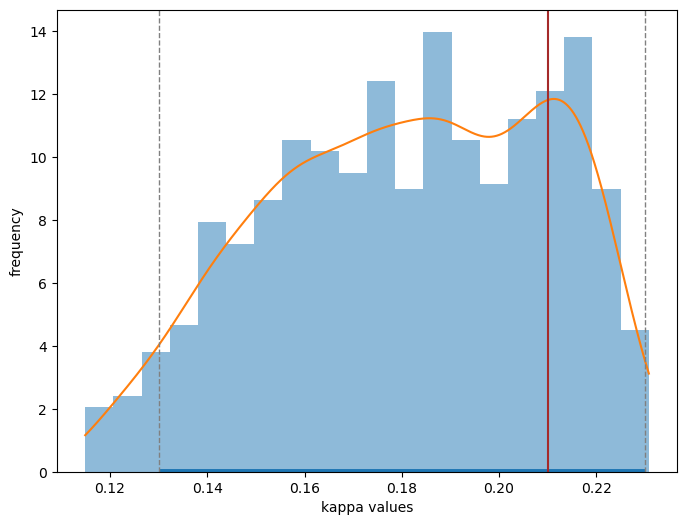

95% HPD Credible Interval(s) for kappa:
  [0.1300, 0.2300]


In [14]:
from hpd import hpd_grid
hpd_kappa, x_kappa, y_kappa, modes_kappa = hpd_grid(kappa_accepted)
plt.figure(figsize=(8,6))
# raw data
plt.hist(kappa_accepted, density=True, bins=20, alpha=0.5)
# estimated distribution
plt.xlabel(r'kappa values')
plt.ylabel(r'frequency')
plt.plot(x_kappa, y_kappa)
# high density intervals
for (x0, x1) in hpd_kappa:
    plt.hlines(y=0, xmin=x0, xmax=x1, linewidth=5)
    plt.axvline(x=x0, color='grey', linestyle='--', linewidth=1)
    plt.axvline(x=x1, color='grey', linestyle='--', linewidth=1)
# modes
for xm in modes_kappa:
    plt.axvline(x=xm, color='brown')
    
plt.show()

print("95% HPD Credible Interval(s) for kappa:")
for (x0, x1) in hpd_kappa:
    print(f"  [{x0:.4f}, {x1:.4f}]")
    


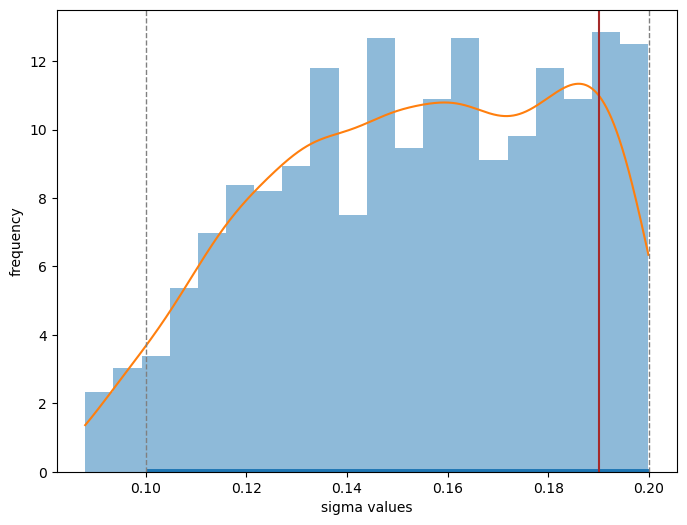

95% HPD Credible Interval(s) for sigma:
  [0.1000, 0.2000]


In [15]:
hpd_sigma, x_sigma, y_sigma, modes_sigma = hpd_grid(sigma_accepted)
plt.figure(figsize=(8,6))

# raw data
plt.hist(sigma_accepted, density=True, bins=20, alpha=0.5)

# estimated distribution
plt.plot(x_sigma, y_sigma)
plt.xlabel(r'sigma values')
plt.ylabel(r'frequency')
# high density intervals
for (x0, x1) in hpd_sigma:
    plt.hlines(y=0, xmin=x0, xmax=x1, linewidth=5)
    plt.axvline(x=x0, color='grey', linestyle='--', linewidth=1)
    plt.axvline(x=x1, color='grey', linestyle='--', linewidth=1)

# modes
for xm in modes_sigma:
    plt.axvline(x=xm, color='brown')

plt.show()

print("95% HPD Credible Interval(s) for sigma:")
for (x0, x1) in hpd_sigma:
    print(f"  [{x0:.4f}, {x1:.4f}]")


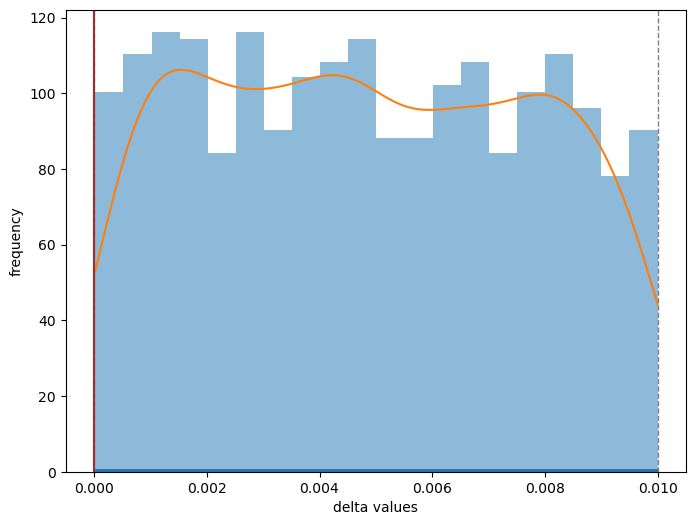

95% HPD Credible Interval(s) for delta:
  [0.0000, 0.0100]


In [16]:
hpd_delta, x_delta, y_delta, modes_delta = hpd_grid(delta_accepted)
plt.figure(figsize=(8,6))

# raw data
plt.hist(delta_accepted, density=True, bins=20, alpha=0.5)
plt.xlabel(r'delta values')
plt.ylabel(r'frequency')
# estimated distribution
plt.plot(x_delta, y_delta)

# high density intervals
for (x0, x1) in hpd_delta:
    plt.hlines(y=0, xmin=x0, xmax=x1, linewidth=5)
    plt.axvline(x=x0, color='grey', linestyle='--', linewidth=1)
    plt.axvline(x=x1, color='grey', linestyle='--', linewidth=1)

# modes
for xm in modes_delta:
    plt.axvline(x=xm, color='brown')

plt.show()

print("95% HPD Credible Interval(s) for delta:")
for (x0, x1) in hpd_delta:
    print(f"  [{x0:.4f}, {x1:.4f}]")


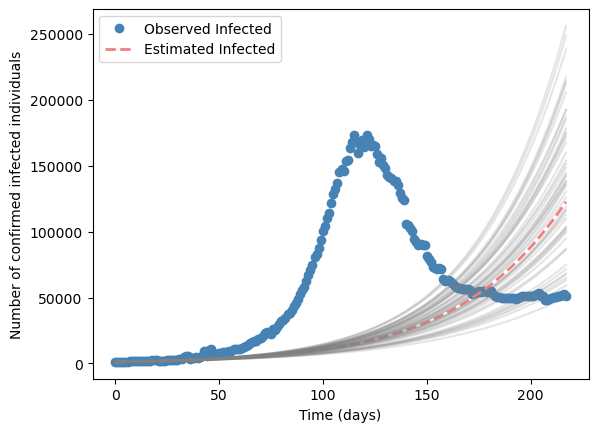

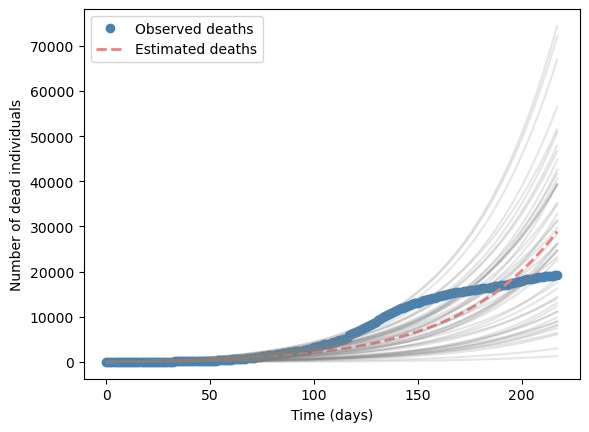

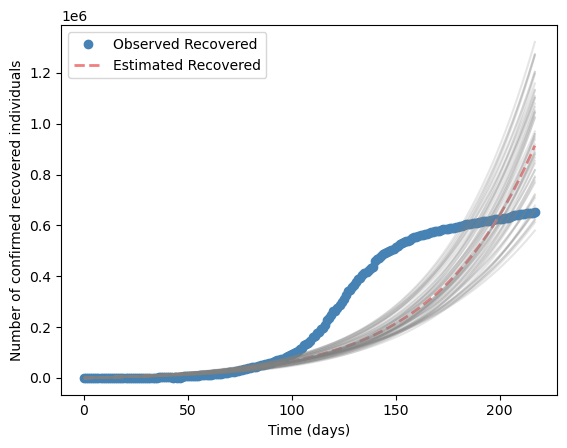

In [17]:
#Solve SIRD using estimated mean parameters
sol_est2 = odeint(sird_model, y0, t_obs, args=(kk, ss, dd))
S_est, I_est, R_est, D_est = sol_est2.T



#Plot true vs. estimated confirmed infections
plt.figure()
plt.plot(t_obs, num_confirmed-num_deaths-num_recovered, 'o', label='Observed Infected',color ='steelblue')
plt.plot(t_obs, I_est, '--', linewidth=2, label='Estimated Infected', color='lightcoral')
for i in range(50):
    sol_sample = odeint(sird_model, y0, t_obs, args=(kappa_accepted[i], sigma_accepted[i],delta_accepted[i]))
    _, I_sample,_ , _= sol_sample.T
    plt.plot(t_obs, I_sample, color='gray', alpha=0.2)
plt.xlabel('Time (days)')
plt.ylabel('Number of confirmed infected individuals')
plt.legend()
#plt.grid(True)
plt.show()


#Plot true vs. estimated deaths
plt.figure()
plt.plot(t_obs, num_deaths, 'o', label='Observed deaths',color ='steelblue')
plt.plot(t_obs, D_est, '--', linewidth=2, label='Estimated deaths', color='lightcoral')
for i in range(50):
    sol_sample = odeint(sird_model, y0, t_obs, args=(kappa_accepted[i], sigma_accepted[i],delta_accepted[i]))
    _, _,_ , D_sample= sol_sample.T
    plt.plot(t_obs, D_sample, color='gray', alpha=0.2)
plt.xlabel('Time (days)')
plt.ylabel('Number of dead individuals')
plt.legend()
#plt.grid(True)
plt.show()


#Plot true vs. estimated recovered
plt.figure()
plt.plot(t_obs, num_recovered, 'o', label='Observed Recovered',color ='steelblue')
plt.plot(t_obs, R_est, '--', linewidth=2, label='Estimated Recovered', color='lightcoral')
for i in range(50):
    sol_sample = odeint(sird_model, y0, t_obs, args=(kappa_accepted[i], sigma_accepted[i],delta_accepted[i]))
    _, _,R_sample,_= sol_sample.T
    plt.plot(t_obs, R_sample, color='gray', alpha=0.2)
plt.xlabel('Time (days)')
plt.ylabel('Number of confirmed recovered individuals')
plt.legend()
#plt.grid(True)
plt.show()



443073


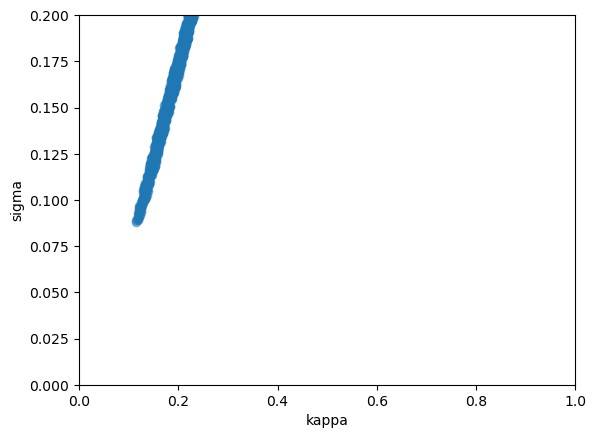

In [18]:
#Scatter plot of accepted parameters
plt.figure()
plt.scatter(kappa_accepted, sigma_accepted, alpha=0.5)
plt.xlabel(r'kappa')
plt.ylabel(r'sigma')
#plt.title('Accepted Parameter Values')
plt.xlim([0,1])
plt.ylim([0.0,0.2])
plt.grid(False)
# plt.show()

plt.savefig('accepted_parameter_values.pdf')

print(nsamp)

443073


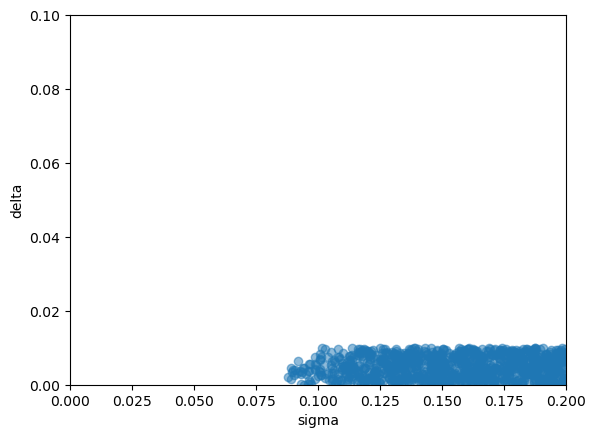

In [19]:


#Scatter plot of accepted parameters
plt.figure()
plt.scatter(sigma_accepted, delta_accepted, alpha=0.5)
plt.xlabel(r'sigma')
plt.ylabel(r'delta')
#plt.title('Accepted Parameter Values')
plt.xlim([0,0.2])
plt.ylim([0.0,0.1])
plt.grid(False)
# plt.show()

plt.savefig('accepted_parameter_values.pdf')

print(nsamp)